**This is an RFM-analysis of an online-store based on K-Means Clustering. I also analysed this dataset based on the distribution of values for recency, frequency, and monetary value. You can find it in My Projects --> RFM_analysis.**<br/>
<br/>
The dataset was downloaded from kaggle.com --> <a href="https://www.kaggle.com/carrie1/ecommerce-data">E-Commerce Data.</a>  Below is its description:<br/>
"This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers."

# STAGE 1. DATA PREPROCESSING

**I have already created a matrix with Recency, Frequency and Monetary values.<br/> To see how I did so please go to My projects--> RFM_analysis** 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df=pd.read_csv('C:/Users/Yoga/ML/RFM.csv',index_col=0)

In [3]:
df.head()

,CustomerID,recency,frequency,monetary_value
0,12346,325,1,77183.60
1,12347,1,6,3598.21
2,12348,74,3,904.44
3,12349,18,1,1757.55
4,12350,309,1,334.40


Let's see how the customers are distributed based on recency and monetary value.

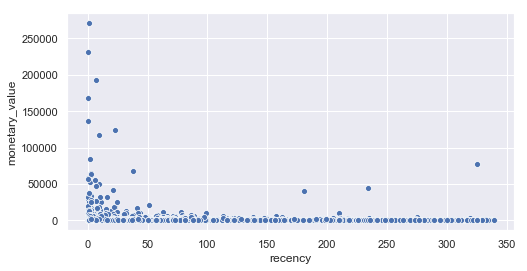

In [4]:
sns.set(rc={'figure.figsize':(8.0, 4.0)})
sns.scatterplot(x='recency',y='monetary_value', data=df)

**DISTRIBUTION OF RECENCY** <br/>

C:\Users\Yoga\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


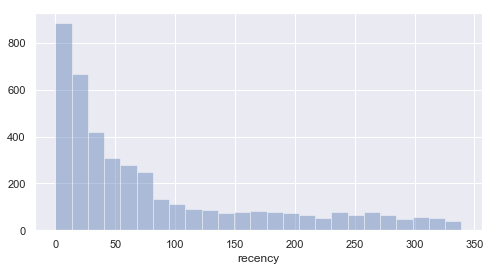

In [5]:
sns.distplot(df.recency, kde=False)

**DISTRIBUTION OF MONETARY VALUE** <br/>

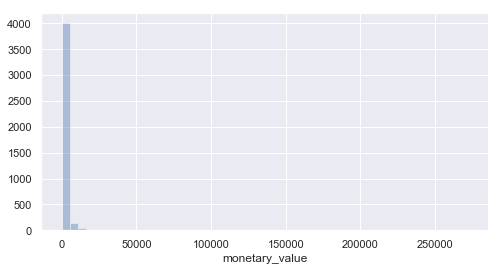

In [6]:
sns.distplot(df.monetary_value, kde=False)

We can see that due to outliers we can't really see the distribution of values below 50000. Let's use logarithmic values of monetary values for a better model.

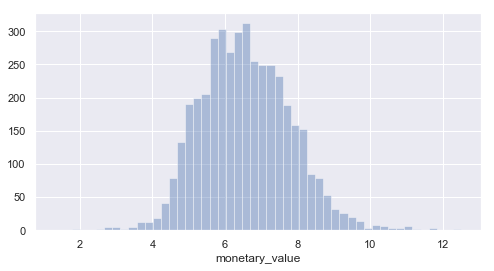

In [7]:
sns.distplot(np.log(df.monetary_value),kde=False)

We can see that now our monetary values are more or less normaly distributed which is needed for a better model. But we can do even better by finding an average amount of money spent during each purchase. As 80 , say pounds, spent once and 80 pounds spend in total over the 3 purchases have different meanings. So, let's create a column with average monetary value and find its logarithmic value for a better distribution.

In [8]:
df['average_monetary_value'] = df.monetary_value / df.frequency

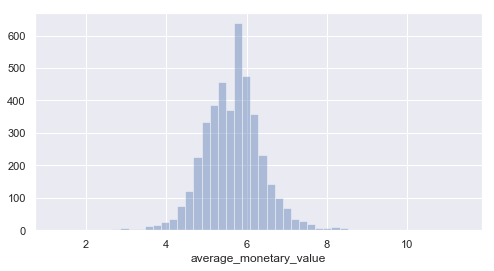

In [9]:
sns.distplot(np.log(df.average_monetary_value),kde=False)

In [10]:
df['average_monetary_log'] = np.log(df.average_monetary_value)

Let's create a scatter plot to see if we can find clusters for a further analysis.

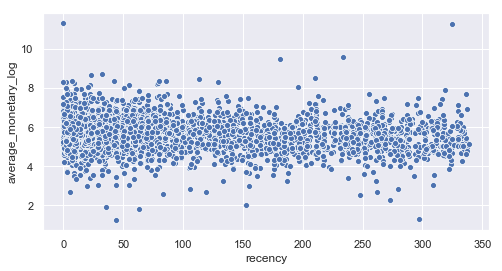

In [11]:
sns.scatterplot(x='recency',y='average_monetary_log', data=df)

Now we can actually identify clusters. Compare that to the initial scatter plot of recency and monetary value, where we couldn't really find clusters due to outliers. 

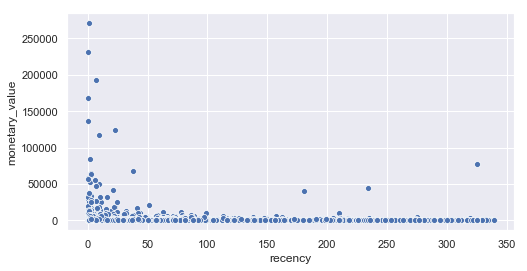

In [12]:
sns.set(rc={'figure.figsize':(8.0, 4.0)})
sns.scatterplot(x='recency',y='monetary_value', data=df)

Let's see a scatter plot by frequency and monetary value.

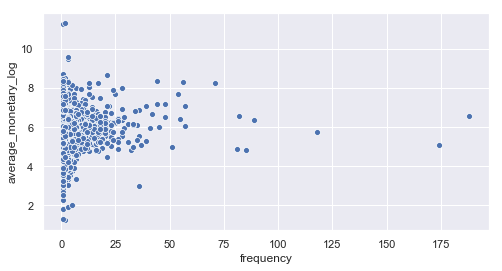

In [13]:
sns.scatterplot(x='frequency',y= 'average_monetary_log', data=df)

# STAGE 2. TRAINING THE K-MEANS MODEL

**ELBOW METHOD FOR FINDING THE OPTIMAL NUMBER OF CLUSTERS**

In [14]:
from sklearn.cluster import KMeans

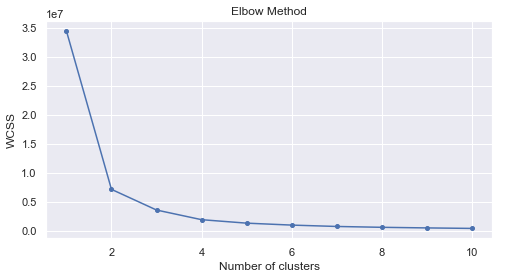

In [15]:
wcss=[]
for i in range(1,11):
    kmeans=KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(df[['average_monetary_log', 'recency', 'frequency']])
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss, markersize=4, marker='o',)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

We can see from the graph that 3 clusters are optimal and more clusters brings insignificant imporvements.<br/> Let's train the model using 3 clusters and 'K-Means ++' for assigning centroids correctly. 

In [16]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)

In [17]:
X = df.iloc[:, [1,2,5]].values
X

array([[325.        ,   1.        ,  11.25394228],
       [  1.        ,   6.        ,   6.39643231],
       [ 74.        ,   3.        ,   5.70870368],
       ...,
       [  7.        ,   2.        ,   4.48891723],
       [  3.        ,  16.        ,   4.85082348],
       [ 42.        ,   3.        ,   6.41742921]])

In [18]:
y_kmeans = kmeans.fit_predict(X)
y_kmeans

array([2, 0, 0, ..., 0, 0, 0])

In [19]:
#Let's add clusters to our dataframe
df['cluster'] = y_kmeans

In [20]:
df.head()

,CustomerID,recency,frequency,monetary_value,average_monetary_value,average_monetary_log,cluster
0,12346,325,1,77183.60,77183.600000,11.253942,2
1,12347,1,6,3598.21,599.701667,6.396432,0
2,12348,74,3,904.44,301.480000,5.708704,0
3,12349,18,1,1757.55,1757.550000,7.471676,0
4,12350,309,1,334.40,334.400000,5.812338,2


Let's find median and mean values for recency, frequency and monetary value and count the number of customers in each group.

In [21]:
segments = df.groupby('cluster', as_index=False)\
.agg({'recency':'mean','frequency':'mean', 'average_monetary_value':'mean',\
      'average_monetary_log':'mean','CustomerID':'count'})\
.sort_values(by='CustomerID', ascending=False)\
.rename(columns={'CustomerID':'customers_count','recency':'mean_recency',\
                 'frequency':'mean_frequency','average_monetary_value':'mean_average_monetary'})
segments.head()

,cluster,mean_recency,mean_frequency,mean_average_monetary,average_monetary_log,customers_count
0,0,29.163280,5.200713,425.716567,5.710580,2805
1,1,135.788945,2.198492,370.949739,5.561533,796
2,2,264.993528,1.284790,474.543967,5.469854,618


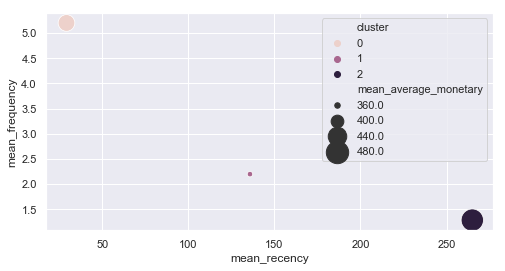

In [22]:
sns.set(rc={'figure.figsize':(8.0, 4.0)})
sns.scatterplot(x='mean_recency', y='mean_frequency', hue='cluster', size='mean_average_monetary',\
                sizes=(30, 500), data=segments)

In [23]:
segments_median = df.groupby('cluster', as_index=False)\
.agg({'recency':'median','frequency':'median', 'average_monetary_value':'median',\
      'average_monetary_log':'median','CustomerID':'count'})\
.sort_values(by='CustomerID', ascending=False)\
.rename(columns={'CustomerID':'customers_count','recency':'median_recency',\
                 'frequency':'median_frequency','average_monetary_value':'median_average_monetary'})
segments_median.head()

,cluster,median_recency,median_frequency,median_average_monetary,average_monetary_log,customers_count
0,0,23,3,308.616667,5.732100,2805
1,1,133,2,278.591545,5.629745,796
2,2,263,1,230.975000,5.442288,618


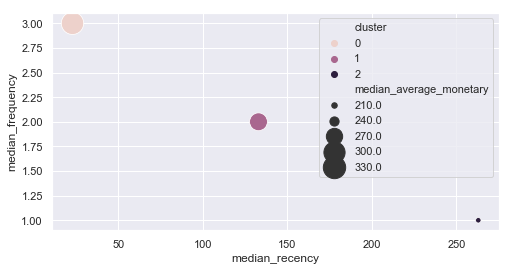

In [24]:
sns.set(rc={'figure.figsize':(8.0, 4.0)})
sns.scatterplot(x='median_recency', y='median_frequency', hue='cluster', size='median_average_monetary',\
                sizes=(30, 500), data=segments_median)

We can see that while mean and median recency and frequency are similar, mean and median monetary values are very far from each other. This means that the clusters have outliers which drag mean values up. Let's how the model assigned the centroids and identified clusters.

# STAGE 3. VISUALISING THE CLUSTERS

In [25]:
df.head()

,CustomerID,recency,frequency,monetary_value,average_monetary_value,average_monetary_log,cluster
0,12346,325,1,77183.60,77183.600000,11.253942,2
1,12347,1,6,3598.21,599.701667,6.396432,0
2,12348,74,3,904.44,301.480000,5.708704,0
3,12349,18,1,1757.55,1757.550000,7.471676,0
4,12350,309,1,334.40,334.400000,5.812338,2


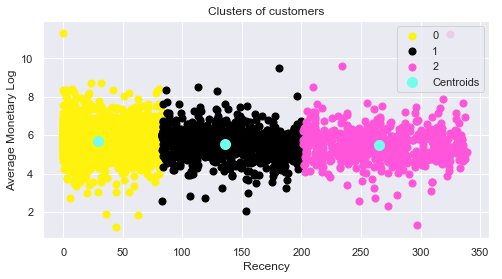

In [26]:
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 2], s = 50, c = '#fff30e', label = '0')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 2], s = 50, c = '#000000', label = '1')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 2], s = 50, c = '#ff55da', label = '2')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 2], s = 100, c = '#70ffec',\
            label = 'Centroids')
plt.title('Clusters of customers')
plt.xlabel('Recency')
plt.ylabel('Average Monetary Log')
plt.legend()
plt.show()

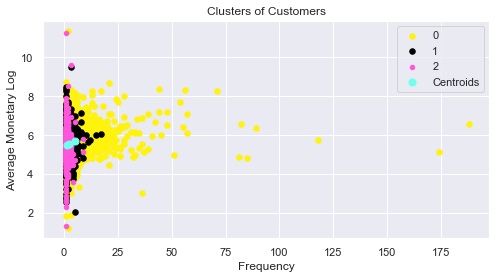

In [27]:
plt.scatter(X[y_kmeans == 0, 1], X[y_kmeans == 0, 2], s = 30, c = '#fff30e', label = '0')
plt.scatter(X[y_kmeans == 1, 1], X[y_kmeans == 1, 2], s = 30, c = '#000000', label = '1')
plt.scatter(X[y_kmeans == 2, 1], X[y_kmeans == 2, 2], s = 20, c = '#ff55da', label = '2')
plt.scatter(kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2], s = 50, c = '#70ffec',\
            label = 'Centroids')
plt.title('Clusters of Customers')
plt.xlabel('Frequency')
plt.ylabel('Average Monetary Log')
plt.legend()
plt.show()

Cluster 0 has the most recent and the most frequent customers with different monetary values. It's our best customers. Cluster 2 is the worst performing group, as they are the least frequent and the least recent.<br/>
Let's see how they are distributed by recency and frequency.

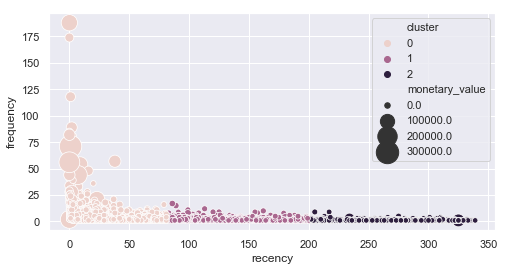

In [28]:
sns.set(rc={'figure.figsize':(8.0, 4.0)})
sns.scatterplot(x='recency',y='frequency',hue='cluster', size='monetary_value', sizes=(30, 500), data=df)

Here we can see those big spenders in cluster 2 that have dragged up the average monetary value. We can treat them separately from the cluster 2. 

# CONCLUSION

Thus, we can clearly see that the model has taken recency as its main criterion. I'd actually tried to run the model eliminating frequency, I've got the same results. While I'd tried to run the model without recency, it has taken frequency as its main criterion. Obviously, monetary value is not its main priority. So, I am not sure which model is better: the one based on the distribution of values for recency, frequency, and monetary value or this one. Anyway, thanks to the K-Means Clustering we've learned that 3 segments are likely to be enough for marketing.  